In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import sys

if 'google.colab' in sys.modules:
  %tensorflow_version 2.x

import tensorflow as tf


tf.random.set_seed(1234)
AUTO = tf.data.experimental.AUTOTUNE

!pip install tensorflow-datasets==1.2.0
import tensorflow_datasets as tfds

import os
import re
import numpy as np
from time import time
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import MultiHeadAttention

print("Tensorflow version {}".format(tf.__version__))

     |████████████████████████████████| 2.3 MB 12.8 MB/s 
  Attempting uninstall: tensorflow-datasets
    Found existing installation: tensorflow-datasets 4.0.1
    Uninstalling tensorflow-datasets-4.0.1:
      Successfully uninstalled tensorflow-datasets-4.0.1
Tensorflow version 2.8.0


In [ ]:
import random

In [ ]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  print('Running on TPU {}'. format(tpu.cluster_spec().as_dict()['worker']))
except ValueError:
  tpu = None

if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
  strategy = tf.distribute.get_strategy()

print('replicas: {}'.format(strategy.num_replicas_in_sync))

replicas: 1


In [ ]:
# Maximum sentence length
MAX_LENGTH = 50

# Maximum number of samples to preprocess
MAX_SAMPLES = 1500

# For tf.data.Dataset
BATCH_SIZE = 8* strategy.num_replicas_in_sync
BUFFER_SIZE = 200


In [ ]:
from google.colab import files
up = files.upload()

Saving Web Scrapped data.csv to Web Scrapped data.csv


In [ ]:
data = pd.read_csv('Web Scrapped data.csv', encoding = 'latin')

In [ ]:
data

,Questions,Answers
0,What is Machine Learning?,Machine learning is the science of getting co...
1,Explain the basic difference between Supervise...,Supervised Learning: A model is trained on the...
2,What do you mean by Reinforcement Learning?,reinforcement learning is an area of machine ...
3,What are the different types of data used in M...,There Are Two Types of Data. Structured and U...
4,Features vs. Labels?,Features are the input information. On the ot...
...,...,...
221,What's the difference between 'correlation' a...,This will be one of the advanced machine learn...
222,Describe an 'imbalanced dataset'.,"An imbalanced dataset is a set that, after tes..."
223,What is 'data normalization'?,Remember when we talked about 'backpropagation...
224,Could you capture the correlation between cat...,"Well, you could, but you would have to use wha..."


In [ ]:
def preprocess_sentence(w):

    w = w.lower().strip()

     # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿0-9]+", " ", w)

    w = w.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.

    return w

In [ ]:
questions = []

for question in data.Questions:
    question = str(question)
    question = preprocess_sentence(question)
    questions.append(question)

In [ ]:
questions[:10]

['what is machine learning ?',
 'explain the basic difference between supervised , unsupervised , and semi supervised machine learning ?',
 'what do you mean by reinforcement learning ?',
 'what are the different types of data used in machine learning ?',
 'features vs . labels ?',
 'explain the difference between regression and classification ?',
 'what is scikit learn used for ?',
 'what are a training set and test set in machine learning , and why are they important ?',
 'explain the stages of building a machine learning model ?',
 'overfitting vs . underfitting ?']

In [ ]:
answers = []

for answer in data.Answers:
    answer = str(answer)
    answer = preprocess_sentence(answer)
    answers.append(answer)

In [ ]:
answers[:20]

['machine learning is the science of getting computers to act in a real time situation without being explicitly programmed . it is an application of artificial intelligence that provides systems to automatically learn and improve from previous experience . it allows computers to learn and adapt to new data without any kind of human intervention .',
 'supervised learning a model is trained on the labeled data , and then it makes predictions based on the previously labeled data . it requires a supervisor labels to train the data . e . g . , text classification . unsupervised learning a model is trained on unlabeled data . the model tries to find patterns , relationships in the data and classify the classes according to that . we don t have any labeled data . semi supervised learning it is a type of machine learning that uses some amount of labeled data and a large amount of unlabeled data to train the model . the goal of this is to classify some of the unlabeled data with the help of lab

In [ ]:
print(questions[20])
print('\n')
print(answers[20])

explain l1 and l2 regularization ?


a regression model that uses l1 regularization is called lasso regression , and the model which uses l2 regularization is called ridge regression . l1 regularization adds the penalty term in the cost function by adding the absolute value of weight wj , while l2 regularization adds the squared value of weights wj in the cost function . one more difference between both of them is that l1 regularization tries to estimate the median of the data while l2 regularization tries to estimate the mean of the data . l1 regularization helps in eliminating the features that are not important .


In [ ]:
# Build tokenizer using tfds for both questions and answers
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size= 2100)

# Define start and end token to indicate the start and end of a sentence
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# Vocabulary size plus start and end token
VOCAB_SIZE = tokenizer.vocab_size + 2

In [ ]:
print(f' Start token: {START_TOKEN} \n   End token: {END_TOKEN} \n Vocab size: {VOCAB_SIZE}')

 Start token: [2001] 
   End token: [2002] 
 Vocab size: 2003


In [ ]:
print(f' sample question: {questions[21]} \n tokenized sample question: {tokenizer.encode(questions[21])}')

 sample question: what are the different ways to handle missing values in machine learning ? 
 tokenized sample question: [21, 14, 1, 88, 1218, 1777, 7, 233, 341, 51, 9, 35, 87, 16]


In [ ]:
# Tokenize, filter and pad sentences
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
    # tokenize sentence
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        # check tokenized sentence max length
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
        tokenized_inputs.append(sentence1)
        tokenized_outputs.append(sentence2)

    # pad tokenized sentences
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs


questions, answers = tokenize_and_filter(questions, answers)

In [ ]:
print(f' vocab size: {VOCAB_SIZE}')

 vocab size: 2003


In [ ]:
# decoder inputs use the previous target as input
# remove START_TOKEN from targets
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
print(dataset)

<PrefetchDataset element_spec=({'inputs': TensorSpec(shape=(None, 50), dtype=tf.int32, name=None), 'dec_inputs': TensorSpec(shape=(None, 49), dtype=tf.int32, name=None)}, {'outputs': TensorSpec(shape=(None, 49), dtype=tf.int32, name=None)})>


In [ ]:
def scaled_dot_product_attention(query, key, value, mask):
    """ Calculating the attention weights"""
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # scale matmul_qk
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # add the mask to zero out padding tokens
    if mask is not None:
        logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k)
    attention_weights = tf.nn.softmax(logits, axis=-1)

    output = tf.matmul(attention_weights, value)

    return output

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def get_config(self):
        config = super(MultiHeadAttention, self).get_config()
        config.update({'num_heads': self.num_heads,
                      'd_model': self.d_model,
        })
        return config


    def split_heads(self, inputs, batch_size):
        inputs = tf.keras.layers.Lambda(lambda inputs:tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth)))(inputs)
        return tf.keras.layers.Lambda(lambda inputs: tf.transpose(inputs, perm=[0, 2, 1,3]))(inputs)

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # linear layers
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # split heads
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # scaled dot-product attention
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention =  tf.keras.layers.Lambda(lambda scaled_attention: tf.transpose(
        scaled_attention, perm=[0, 2, 1, 3]))(scaled_attention)

        # concatenation of heads
        concat_attention = tf.keras.layers.Lambda(lambda scaled_attention: tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model)))(scaled_attention)



        # final linear layer
        outputs = self.dense(concat_attention)

        return outputs

In [ ]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x,0), tf.float32)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [ ]:

def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)


In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_config(self):

        config = super(PositionalEncoding, self).get_config()
        config.update({
            'position': self.position,
            'd_model': self.d_model,
        })
        return config

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
    # apply sin to even index in the array
        sines = tf.math.sin(angle_rads[:, 0::2])
        # apply cos to odd index in the array
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

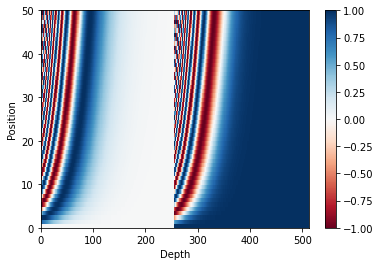

In [ ]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [ ]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):

    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention = MultiHeadAttention(
          d_model, num_heads, name="attention")({
              'query': inputs,
              'key': inputs,
              'value': inputs,
              'mask': padding_mask
          })
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    add_attention = tf.keras.layers.add([inputs, attention])
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    add_attention = tf.keras.layers.add([attention, outputs])
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [ ]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.keras.layers.Lambda(lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32)))(d_model)
    embeddings = PositionalEncoding(vocab_size,d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [ ]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):

    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")

    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })
    add_attention = tf.keras.layers.add([attention1, inputs])
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    add_attention = tf.keras.layers.add([attention2, attention1])
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    add_attention = tf.keras.layers.add([outputs, attention2])
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [ ]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.keras.layers.Lambda( lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32)))(d_model)
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)


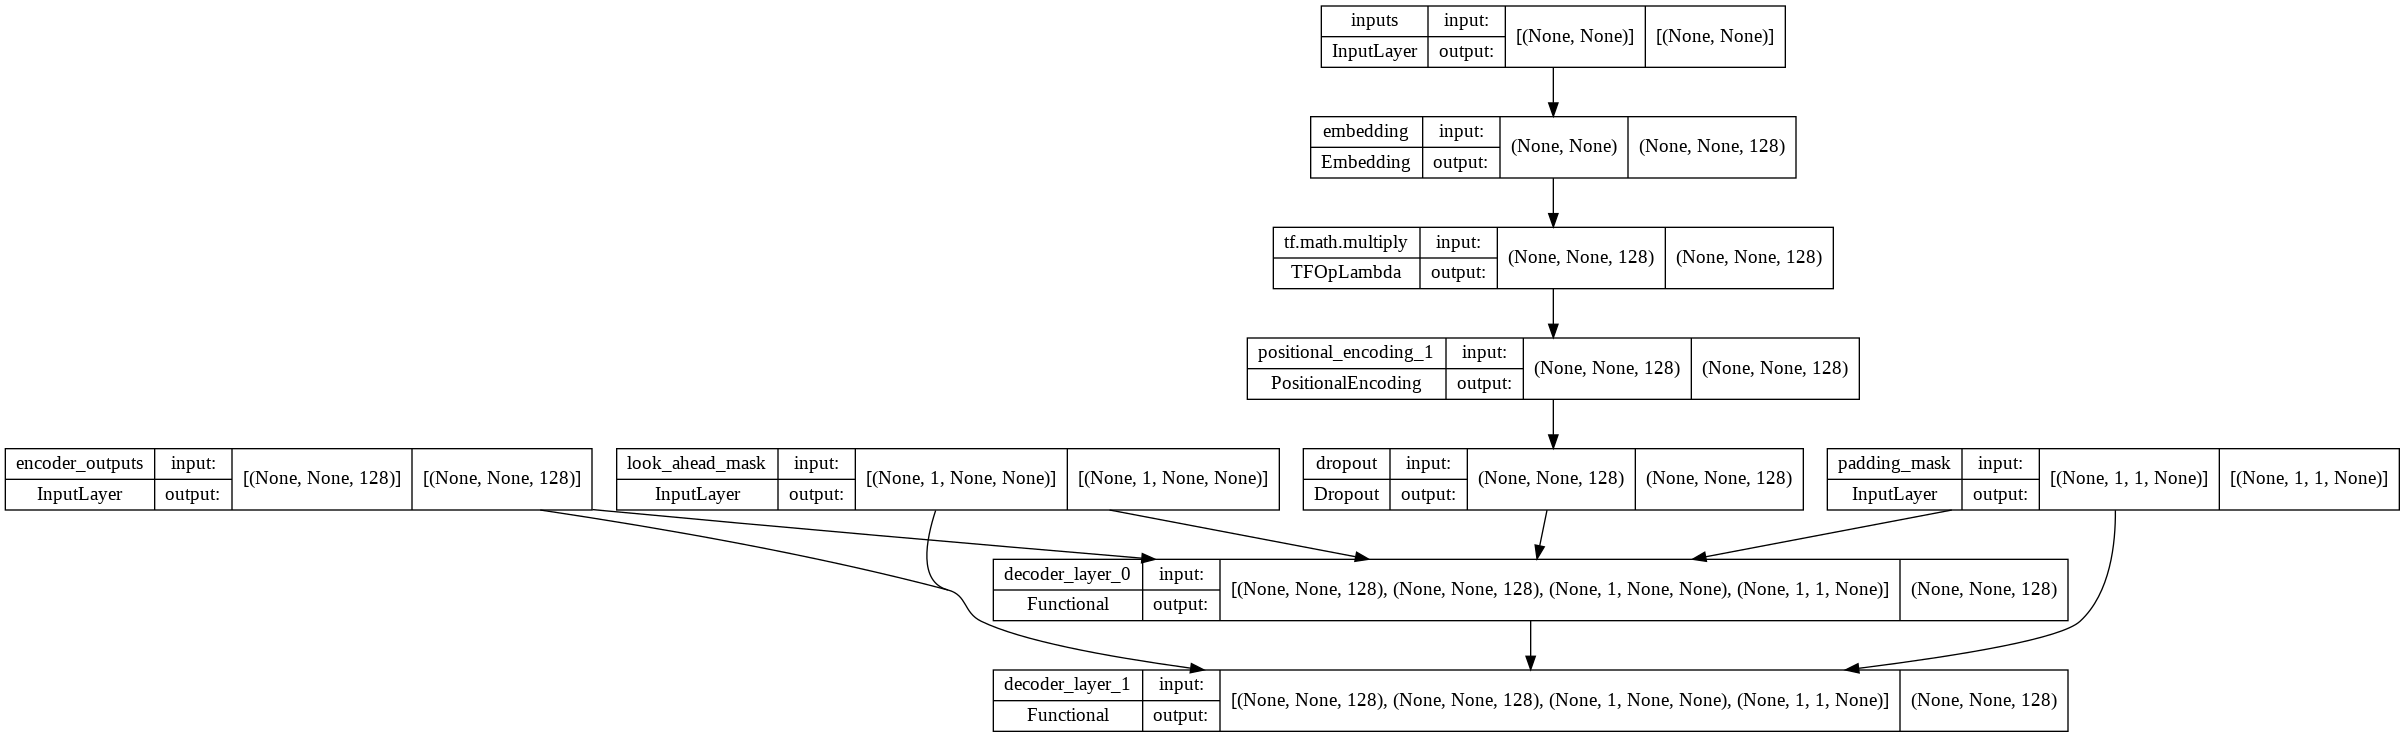

In [ ]:
sample_decoder = decoder(
    vocab_size=2003,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder")

tf.keras.utils.plot_model(
    sample_decoder, to_file='decoder.png', show_shapes=True)


In [ ]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)
  # mask the future tokens for decoder inputs at the 1st attention block
    look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)
  # mask the encoder outputs for the 2nd attention block
    dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

    enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs = [inputs, dec_inputs], outputs = outputs, name = name)

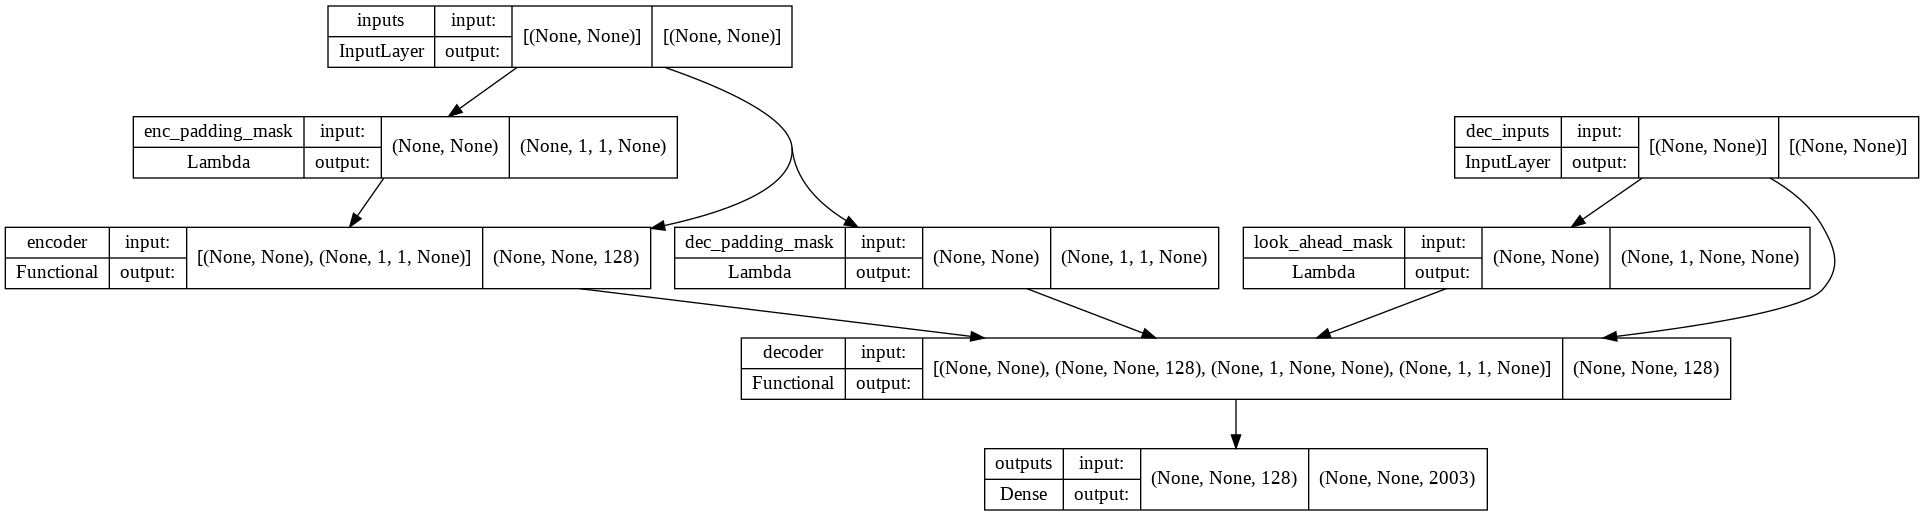

In [ ]:
sample_transformer = transformer(vocab_size = 2003, num_layers = 4, units = 512, d_model = 128, num_heads = 4, dropout = 0.3, name = 'sample_transformer')

tf.keras.utils.plot_model(sample_transformer, to_file = 'transformer.png', show_shapes = True)

In [ ]:


# Transformer parameters initialzation
NUM_LAYERS = 8
D_MODEL = 512
NUM_HEADS = 16
UNITS = 1024
DROPOUT = 0.03



In [ ]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()


        self.d_model = tf.constant(d_model, dtype = tf.float32)
        self.warmup_steps = warmup_steps

    def get_config(self):
         return {"d_model": self.d_model,"warmup_steps":self.warmup_steps}

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.multiply(tf.math.rsqrt(self.d_model), tf.math.minimum(arg1, arg2))

Text(0.5, 0, 'Train Step')

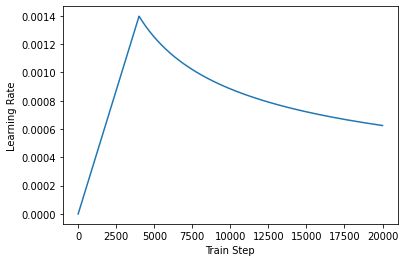

In [ ]:
sample_lr = CustomSchedule(d_model = 128)

plt.plot(sample_lr(tf.range(20000, dtype = tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [ ]:
# clear backend
tf.keras.backend.clear_session()

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

# initialize and compile model within strategy scope
with strategy.scope():
    model = transformer(
            vocab_size=VOCAB_SIZE,
            num_layers=NUM_LAYERS,
            units=UNITS,
            d_model=D_MODEL,
            num_heads=NUM_HEADS,
            dropout=DROPOUT)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

model.summary()


Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 512)    17847808    ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

In [ ]:
model.fit(dataset, epochs = 300)

Epoch 1/300
1/1 [==============================] - 24s 24s/step - loss: 7.2598 - accuracy: 0.0000e+00
Epoch 2/300
1/1 [==============================] - 0s 457ms/step - loss: 7.2472 - accuracy: 0.0000e+00
Epoch 3/300
1/1 [==============================] - 0s 453ms/step - loss: 7.2448 - accuracy: 0.0000e+00
Epoch 4/300
1/1 [==============================] - 0s 456ms/step - loss: 7.2582 - accuracy: 0.0000e+00
Epoch 5/300
1/1 [==============================] - 0s 440ms/step - loss: 7.2366 - accuracy: 0.0000e+00
Epoch 6/300
1/1 [==============================] - 0s 455ms/step - loss: 7.2611 - accuracy: 0.0000e+00
Epoch 7/300
1/1 [==============================] - 0s 453ms/step - loss: 7.2185 - accuracy: 0.0000e+00
Epoch 8/300
1/1 [==============================] - 0s 453ms/step - loss: 7.1924 - accuracy: 0.0000e+00
Epoch 9/300
1/1 [==============================] - 0s 466ms/step - loss: 7.1247 - accuracy: 0.0000e+00
Epoch 10/300
1/1 [==============================] - 0s 451ms/step - loss: 

In [ ]:
def evaluate(sentence):

  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims( START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis = 0)

  output = tf.expand_dims(START_TOKEN, 0)

  for i in range(MAX_LENGTH):
                 predictions = model(inputs = [sentence, output], training = False)

                 predictions = predictions[:, -1:,:]
                 predicted_id=  tf.cast(tf.argmax(predictions, axis = -1), tf.int32)

                 if tf.equal(predicted_id, END_TOKEN[0]):
                   break

                 output = tf.concat([output, predicted_id], axis = -1)
  return tf.squeeze(output, axis = 0)

def predict(sentence):

  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print(f' Question: {sentence}')
  print(f' Answer: {predicted_sentence}')


In [ ]:
out = predict("what is Machine Learning ?")

 Question: what is Machine Learning ?
 Answer: this function allows you to diversify your network by introducing non linear methods of learning . what this will do is that it will help your machine to learn how to process difficult processes more easily .
